# Intro
## General
Machine learning allows the user to feed a computer algorithm an immense amount of data and have the computer analyze and make data-driven recommendations and decisions based on only the input data. 
In most of the situations we want to have a machine learning system to make **predictions**, so we have several categories of machine learning tasks depending on the type of prediction needed: **Classification, Regression, Clustering, Generation**, etc.

**Classification** is the task whose goal is the prediction of the label of the class to which the input belongs (e.g., Classification of images in two classes: cats and dogs).
**Regression** is the task whose goal is the prediction of numerical value(s) related to the input (e.g., House rent prediction, Estimated time of arrival ).
**Generation** is the task whose goal is the creation of something new related to the input (e.g., Text translation, Audio beat generation, Image denoising ). **Clustering** is the task of grouping a set of objects in such a way that objects in the same group (called a **cluster**) are more similar (in some sense) to each other than to those in other **clusters** (e.g., Clients clutering).

In machine learning, there are learning paradigms that relate to one aspect of the dataset: **the presence of the label to be predicted**. **Supervised Learning** is the paradigm of learning that is applied when the dataset has the label variables to be predicted, known as ` y variables`. **Unsupervised Learning** is the paradigm of learning that is applied when the dataset has not the label variables to be predicted. **Self-supervised Learning** is the paradigm of learning that is applied when part of the X dataset is considere as the label to be predicted (e.g., the Dataset is made of texts and the model try to predict the next word of each sentence).

## Notebook overview
This notebook contains the step by step approach undertaken to build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores; a large Ecuadorian-based grocery retailer.

In [1]:
# Data Handling
import warnings
import pyodbc
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from scipy import stats
from dotenv import dotenv_values


# Statistical Analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import ttest_ind
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import itertools

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

warnings.filterwarnings('ignore')

In [2]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

In [3]:
# Create a connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [4]:
connection = pyodbc.connect(connection_string)

## Loading the dataset from the various sources.

In [5]:
query = "Select * from dbo.oil"
oil_data = pd.read_sql(query, connection)
oil_data.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [6]:
query = "Select * from dbo.stores"
stores_data = pd.read_sql(query, connection)
stores_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [7]:
query = "Select * from dbo.holidays_events"
holiday_events_data = pd.read_sql(query, connection)
holiday_events_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [8]:
train_data= pd.read_csv('Data_Sources/Github_Data/train.csv')
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [9]:
transactions_data= pd.read_csv('Data_Sources/Github_Data/transactions.csv')
transactions_data.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [10]:
sample_submission_data= pd.read_csv('Data_Sources/OneDrive_data/sample_submission.csv')
sample_submission_data.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [11]:
test_data= pd.read_csv('Data_Sources/OneDrive_data/test.csv')
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


## Exploratory Data Analysis.

Analytical Questions:


1. What is the trend in the oil prices over the years?
2. What are the average sales by city? Which city has the highest number of sales?
3. What is the variation of sales with relation to holidays. Do sales on holidays differ with sales on normal days?


        Null Hypothesis: There is no significant difference in sales between holidays and regular days
        Alternate Hypothesis; There is a significant difference in sales between holidays and regular days.
4. Did the earthquake have a significant impact on sales?

        Null Hypothesis: The earthquake has no significant impact on sales
        Alternate Hypthesis: The earthquake has a significant impact on sales

Merging the data set in preparation for Bi & Multi-Variate analysis.

In [12]:
# Merging on the common columns ('store_nbr' and 'date') in the datasets using the inner merge() function
# Merge train_df with stores_df on 'store_nbr' column
merged_df1 = train_data.merge(stores_data, on='store_nbr', how='inner')

# Merge merged_df1 with transactions_df on 'date' and 'store_nbr' columns
merged_df2 = merged_df1.merge(transactions_data, on=['date', 'store_nbr'], how='inner')

# Merge merged_df2 with holidays_events_df on 'date' column
merged_df3 = merged_df2.merge(holiday_events_data, on='date', how='inner')

# Merge merged_df3 with oil_df on 'date' column
merged_df = merged_df3.merge(oil_data, on='date', how='inner')
merged_df['date'] = pd.to_datetime(merged_df['date'])
# View the first five rows of the merged dataset
merged_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73063,2013-02-11,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73064,2013-02-11,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73065,2013-02-11,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73066,2013-02-11,1,BOOKS,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


In [13]:
# Renaming the columns with the approapriate names
merged_df = merged_df.rename(columns={"type_x": "store_type", "type_y": "holiday_type"})
merged_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73063,2013-02-11,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73064,2013-02-11,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73065,2013-02-11,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73066,2013-02-11,1,BOOKS,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


In [14]:
# Create A Copy of The Merged Dataset
merged_df2 = merged_df.copy()

Converting the 'date' column in the datasets to datetime format

In [15]:

# Train dataset
train_data['date'] = pd.to_datetime(train_data['date'])

# Test dataset
test_data['date'] = pd.to_datetime(test_data['date'])

# Holiday Events dataset
holiday_events_data['date'] = pd.to_datetime(holiday_events_data['date'])

# Oil dataset
oil_data['date'] = pd.to_datetime(oil_data['date'])

# Transactions dataset
transactions_data['date'] = pd.to_datetime(transactions_data['date'])

#### Check for the summary statistics of the various data sets.

In [16]:
# Checking for the summary statistics of the datasets 
datasets = {'train': train_data, 'test': test_data, 'holiday events': holiday_events_data, 'oil': oil_data, 'stores': stores_data, 'transactions': transactions_data}

for name, data in datasets.items():
    print(f"{name.capitalize()} dataset summary statistics:")
    print('---'*15)
    print(data.describe())
    print('==='*20)
    print()

Train dataset summary statistics:
---------------------------------------------
                 id                           date     store_nbr  \
count  3.000888e+06                        3000888  3.000888e+06   
mean   1.500444e+06  2015-04-24 08:27:04.703088384  2.750000e+01   
min    0.000000e+00            2013-01-01 00:00:00  1.000000e+00   
25%    7.502218e+05            2014-02-26 18:00:00  1.400000e+01   
50%    1.500444e+06            2015-04-24 12:00:00  2.750000e+01   
75%    2.250665e+06            2016-06-19 06:00:00  4.100000e+01   
max    3.000887e+06            2017-08-15 00:00:00  5.400000e+01   
std    8.662819e+05                            NaN  1.558579e+01   

              sales   onpromotion  
count  3.000888e+06  3.000888e+06  
mean   3.577757e+02  2.602770e+00  
min    0.000000e+00  0.000000e+00  
25%    0.000000e+00  0.000000e+00  
50%    1.100000e+01  0.000000e+00  
75%    1.958473e+02  0.000000e+00  
max    1.247170e+05  7.410000e+02  
std    1.101998e+03

##### Check for missing data in the datasets.


In [17]:
# Check for missing values in the datasets
datasets = {'train': train_data, 'test': test_data, 'holiday events': holiday_events_data, 'oil': oil_data, 'stores': stores_data, 'transactions': transactions_data, }

def show_missing_values(datasets):
    for name, data in datasets.items():
        print(f"Missing values in the {name.capitalize()} dataset:")
        print(data.isnull().sum())
        print('===' * 18)
        print()

show_missing_values(datasets)

Missing values in the Train dataset:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Missing values in the Test dataset:
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

Missing values in the Holiday events dataset:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

Missing values in the Oil dataset:
date           0
dcoilwtico    43
dtype: int64

Missing values in the Stores dataset:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

Missing values in the Transactions dataset:
date            0
store_nbr       0
transactions    0
dtype: int64



##### The oil data is seen to have 43 missing values in the oil prices column. The rest of the datasets do not have any missing  values.

### Check for completeness of the train dataset.

In [18]:
# Check the completeness of the train dataset
min_date = train_data['date'].min()
max_date = train_data['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)

missing_dates = expected_dates[~expected_dates.isin(train_data['date'])]

if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

The train dataset is incomplete. The following dates are missing:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


##### Complete the missing dates in the train dataset

In [19]:
 
# Create an index of the missing dates as a DatetimeIndex object
missing_dates = pd.Index(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]')

# Create a DataFrame with the missing dates, using the 'date' column
missing_data = pd.DataFrame({'date': missing_dates})

# Concatenate the original train dataset and the missing data DataFrame
# ignore_index=True ensures a new index is assigned to the resulting DataFrame
train_df = pd.concat([train_data, missing_data], ignore_index=True)
# Sort the DataFrame based on the 'date' column in ascending order
train_df.sort_values('date', inplace=True)

In [20]:
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [21]:
oil_data.shape

(1218, 2)

In [22]:
oil_data=oil_data.set_index('date')
oil_data.index = pd.to_datetime(oil_data.index)
oil_data.head()

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.139999
2013-01-03,92.970001
2013-01-04,93.120003
2013-01-07,93.199997


In [23]:
oil_data['Year'] = oil_data.index.year
oil_data['Month'] = oil_data.index.month
oil_data.sample(5, random_state=0)

,dcoilwtico,Year,Month
date,,,
2017-05-22,50.810001,2017,5
2016-10-18,50.299999,2016,10
2014-10-31,80.529999,2014,10
2013-08-14,106.889999,2013,8
2017-06-02,47.680000,2017,6


In [24]:
oil_data.to_csv("oil_data.csv", index=False)

<Axes: xlabel='date'>

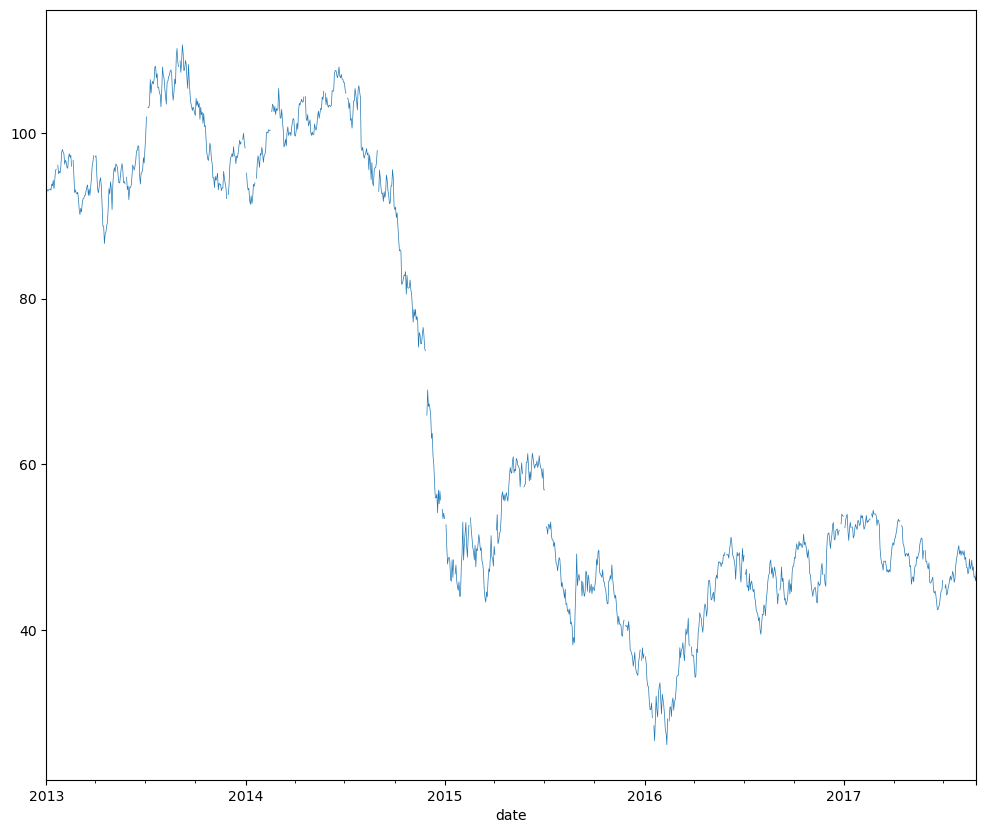

In [25]:
plt.figure(figsize=(12,10))
oil_data['dcoilwtico'].plot(linewidth = 0.5)

### Insights derived from oil data

The highest oil prices were recorded in 2013, while the lowest oil prices seen in early 2016.

Generally, there is a decrease in oil prices over the years spanning from 2013 all the way to 2017.

A sharp decline in oil prices is seen in the year 2014, and the prices begin to rise slightly in 2015, before dipping to the lowest prices at the start of 2016. The prices then seem to fluctuate slightly in the year 2017, though still portraying a stable trend. 


What is the trend of daily transactions per store

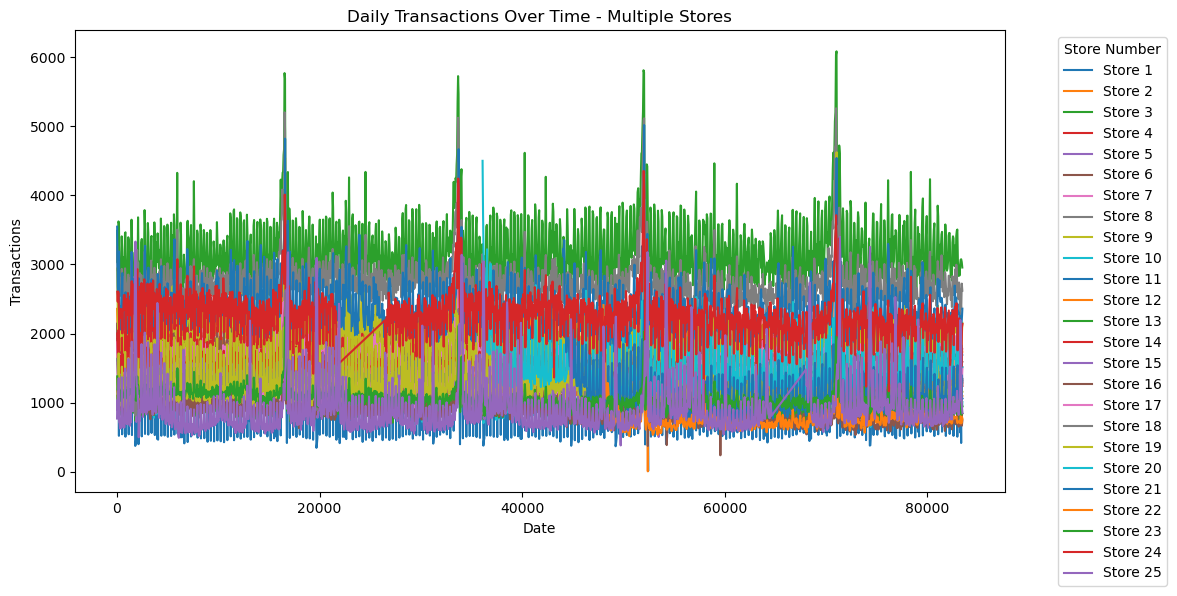

In [26]:
df_transaction_data = transactions_data
# Set 'date' as the index
#df_transaction_data.set_index('date', inplace=True)
plt.figure(figsize=(12, 6))
for store_nbr in range(1, 26):
    df_store = df_transaction_data[df_transaction_data['store_nbr'] == store_nbr]
    sns.lineplot(data=df_store, x=df_store.index, y='transactions', label=f'Store {store_nbr}')

plt.title('Daily Transactions Over Time - Multiple Stores')
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.legend(title='Store Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


What is the transaction distribution by store

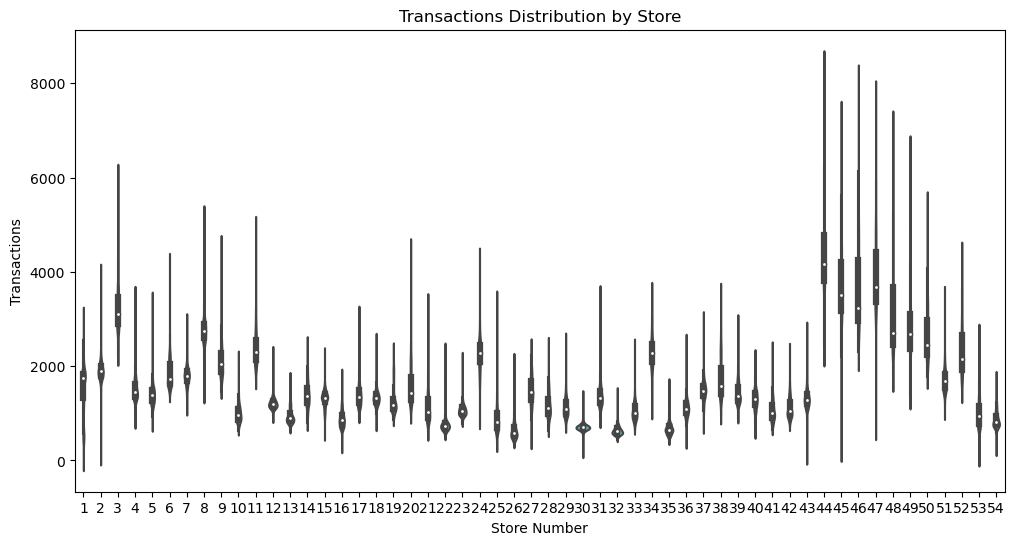

In [27]:
# Transactions Distribution by Store: Violin Plot
plt.figure(figsize=(12, 6))
sns.violinplot(data=transactions_data, x='store_nbr', y='transactions')
plt.title('Transactions Distribution by Store')
plt.xlabel('Store Number')
plt.ylabel('Transactions')
plt.show()


What is the distribution of sales per city

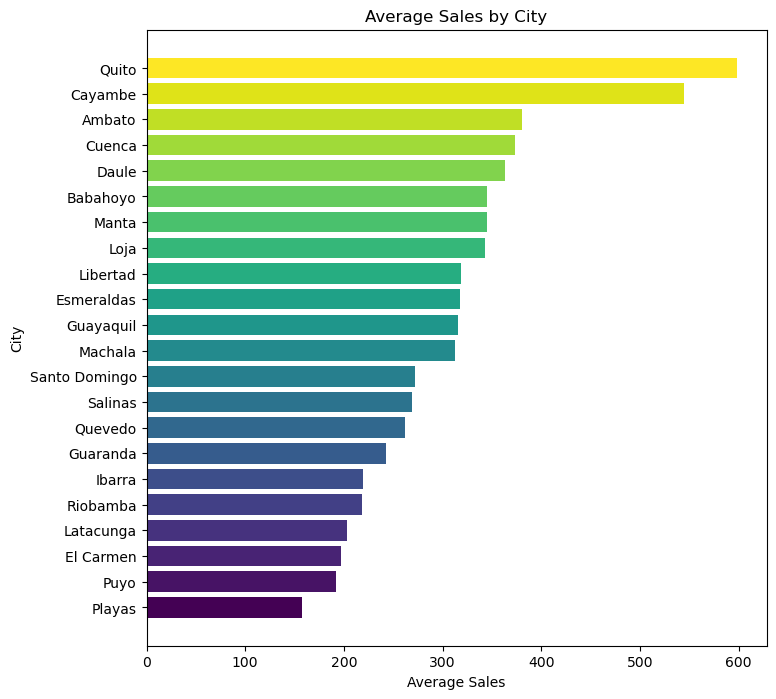

In [28]:
# Group by city and calculate the average sales
average_sales_by_city = merged_df.groupby('city')['sales'].mean()

# Sort the data by average sales in ascending order
average_sales_by_city = average_sales_by_city.sort_values(ascending=True)

# Define colors for the bar plot using 'viridis' color palette
colors = cm.viridis(np.linspace(0, 1, len(average_sales_by_city)))

# Plot the average sales by city horizontally
plt.figure(figsize=(8, 8))
plt.barh(average_sales_by_city.index, average_sales_by_city.values, color=colors)
plt.xlabel('Average Sales')
plt.ylabel('City')
plt.title('Average Sales by City')
plt.show()

The graph shows the distribution of the sales by the various cities. The City of Quito has the highest number of average sales. 

Did the earthquake have a significant impact on sales?

        Null Hypothesis: The earthquake has no significant impact on sales
        Alternate Hypthesis: The earthquake has a significant impact on sales

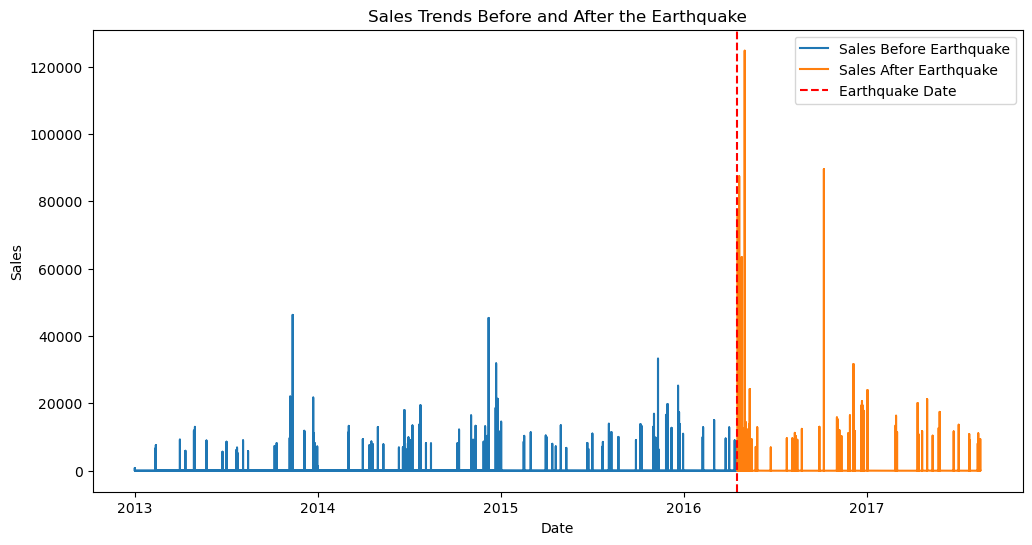

In [29]:


# Define the earthquake date (April 16, 2016)
earthquake_date = pd.to_datetime('2016-04-16')

# Create time series for sales before and after the earthquake
sales_before_earthquake = merged_df[merged_df['date'] < earthquake_date]
sales_after_earthquake = merged_df[merged_df['date'] >= earthquake_date]

# Plot sales trends before and after the earthquake
plt.figure(figsize=(12, 6))
plt.plot(sales_before_earthquake['date'], sales_before_earthquake['sales'], label='Sales Before Earthquake')
plt.plot(sales_after_earthquake['date'], sales_after_earthquake['sales'], label='Sales After Earthquake')
plt.axvline(x=earthquake_date, color='red', linestyle='--', label='Earthquake Date')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Trends Before and After the Earthquake')
plt.legend()
plt.show()


In [30]:
# Create time series for sales before and after the earthquake
sales_before_earthquake = merged_df[merged_df['date'] < earthquake_date]['sales']
sales_after_earthquake = merged_df[merged_df['date'] >= earthquake_date]['sales']

# Perform two-sample t-test
t_statistic, p_value = stats.ttest_ind(sales_before_earthquake, sales_after_earthquake)

# Define significance level
alpha = 0.05

# Check if there was a significant impact on sales due to the earthquake
print ("p_value:", p_value)

if p_value < alpha:
    print("The earthquake had a significant impact on sales.")
else:
    print("There is no significant evidence of the earthquake impacting sales.")

p_value: 5.925430444027047e-125
The earthquake had a significant impact on sales.


What is the variation of sales with relation to holidays. Do sales on holidays differ with sales on normal days?


        Null Hypothesis: There is no significant difference in sales between holidays and regular days
        Alternate Hypothesis; There is a significant difference in sales between holidays and regular days


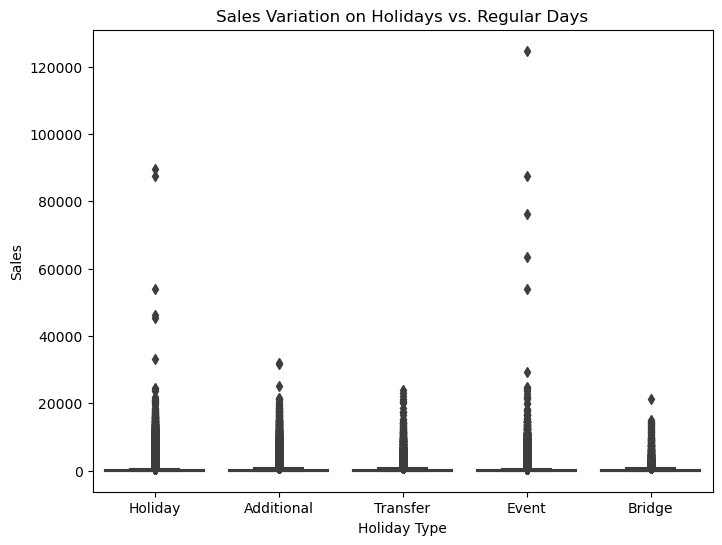

P-value: nan
nan
There is no significant difference in sales between holidays and regular days.


In [31]:
# Box plot to visualize sales variation on holidays and regular days
plt.figure(figsize=(8, 6))
sns.boxplot(x='holiday_type', y='sales', data=merged_df)
plt.xlabel('Holiday Type')
plt.ylabel('Sales')
plt.title('Sales Variation on Holidays vs. Regular Days')
plt.show()

# Check significance in difference
# Separate sales data for holidays and regular days
sales_on_holidays = merged_df[merged_df['holiday_type'] == 'Holiday']['sales']
sales_on_regular_days = merged_df[merged_df['holiday_type'] == 'Regular']['sales']

# Perform two-sample t-test
t_stat, p_value = stats.ttest_ind(sales_on_holidays, sales_on_regular_days, equal_var=False)

# Print the p-value
print("P-value:", p_value)

# Define significance level
alpha = 0.05

# Check the p-value to determine significance
print (p_value)

if p_value < alpha:
    print("There is a significant difference in sales between holidays and regular days.")
else:
    print("There is no significant difference in sales between holidays and regular days.")

From the p-value (Nan)< alpha, we accept the null hypothesis as above.

### Feature Engineering

Here we drop features that are not going to be needed for modelling

In [32]:
# Group and drop columns not needed for modelling
columns_to_drop = ['id', 'locale', 'locale_name', 'description', 'store_type', 'transferred', 'state']
merged_df_copy = merged_df2.drop(columns=columns_to_drop)

merged_df2.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73063,2013-02-11,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73064,2013-02-11,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73065,2013-02-11,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73066,2013-02-11,1,BOOKS,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


In [33]:
# Drop Unneccessary columns (ID column) in the test dataset
test_data.drop('id', axis=1, inplace=True)
test_data.head()

,date,store_nbr,family,onpromotion
0,2017-08-16,1,AUTOMOTIVE,0
1,2017-08-16,1,BABY CARE,0
2,2017-08-16,1,BEAUTY,2
3,2017-08-16,1,BEVERAGES,20
4,2017-08-16,1,BOOKS,0


In [34]:
# Extracting Date Components
merged_df2['date'] = pd.to_datetime(merged_df2['date'])
merged_df2['year'] = merged_df2['date'].dt.year
merged_df2['month'] = merged_df2['date'].dt.month
merged_df2['day'] = merged_df2['date'].dt.day
merged_df2['dayofweek'] = merged_df2['date'].dt.weekday
merged_df2.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,holiday_type,locale,locale_name,description,transferred,dcoilwtico,year,month,day,dayofweek
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Carnaval,False,97.010002,2013,2,11,0
1,73063,2013-02-11,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Carnaval,False,97.010002,2013,2,11,0
2,73064,2013-02-11,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Carnaval,False,97.010002,2013,2,11,0
3,73065,2013-02-11,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Carnaval,False,97.010002,2013,2,11,0
4,73066,2013-02-11,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Carnaval,False,97.010002,2013,2,11,0


Note the new features: Year, Month, Day, Day of week

### Creation of lag features

In [35]:
# Number of lag features
num_lags = 7 # assuming a weekly seasonality

# Create lagged features for 'sales'
for i in range(1, num_lags + 1):
    merged_df2[f'sales_lag_{i}'] = merged_df2['sales'].shift(i)

# Drop rows with NaN values due to the shifting
merged_df2.dropna(subset=[f'sales_lag_{num_lags}'], inplace=True)

# Check the updated DataFrame
merged_df2.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,month,day,dayofweek,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,sales_lag_7
7,73069,2013-02-11,1,CLEANING,152.000,0,Quito,Pichincha,D,13,...,2,11,0,0.000,96.248,0.000,172.000,0.000,0.000,0.0
8,73070,2013-02-11,1,DAIRY,151.000,0,Quito,Pichincha,D,13,...,2,11,0,152.000,0.000,96.248,0.000,172.000,0.000,0.0
9,73071,2013-02-11,1,DELI,26.321,0,Quito,Pichincha,D,13,...,2,11,0,151.000,152.000,0.000,96.248,0.000,172.000,0.0
10,73072,2013-02-11,1,EGGS,46.000,0,Quito,Pichincha,D,13,...,2,11,0,26.321,151.000,152.000,0.000,96.248,0.000,172.0
11,73073,2013-02-11,1,FROZEN FOODS,22.000,0,Quito,Pichincha,D,13,...,2,11,0,46.000,26.321,151.000,152.000,0.000,96.248,0.0


### Rolling Mean Standard Deviation

The rolling mean, also known as the moving average helps smooth out short-term fluctuations and highlights the overall trend.
The rolling standard deviation calculates the standard deviation of a fixed-size window of consecutive data points as it moves through the time series

In [36]:
# Create rolling window statistics for 'sales'
window_size = 7

# 7-day rolling mean of 'sales'
merged_df2['rolling_mean'] = merged_df2['sales'].rolling(window=window_size).mean()

# 7-day rolling standard deviation of 'sales'
merged_df2['rolling_std'] = merged_df2['sales'].rolling(window=window_size).std()

# Check the updated DataFrame
merged_df2.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,dayofweek,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,sales_lag_7,rolling_mean,rolling_std
7,73069,2013-02-11,1,CLEANING,152.000,0,Quito,Pichincha,D,13,...,0,0.000,96.248,0.000,172.000,0.000,0.000,0.0,NaN,NaN
8,73070,2013-02-11,1,DAIRY,151.000,0,Quito,Pichincha,D,13,...,0,152.000,0.000,96.248,0.000,172.000,0.000,0.0,NaN,NaN
9,73071,2013-02-11,1,DELI,26.321,0,Quito,Pichincha,D,13,...,0,151.000,152.000,0.000,96.248,0.000,172.000,0.0,NaN,NaN
10,73072,2013-02-11,1,EGGS,46.000,0,Quito,Pichincha,D,13,...,0,26.321,151.000,152.000,0.000,96.248,0.000,172.0,NaN,NaN
11,73073,2013-02-11,1,FROZEN FOODS,22.000,0,Quito,Pichincha,D,13,...,0,46.000,26.321,151.000,152.000,0.000,96.248,0.0,NaN,NaN


### Train-Test Split

Splitting the data into test and train data.

In [37]:
# Define the cutoff date for train-test split
cutoff_date = pd.to_datetime('2016-08-01')

# Split the data into training and testing sets
train_df = merged_df2[merged_df2['date'] < cutoff_date]
test_df = merged_df2[merged_df2['date'] >= cutoff_date]

# Check the shapes of the training and testing sets
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

Training set shape: (245150, 30)
Testing set shape: (76890, 30)


### Modelling

#### Stationarity test

In [38]:
# stationarity test
def adf_test(timeseries):
    result = adfuller(timeseries)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")
    if result[1] <= 0.05:
        print("The data is stationary.")
        return True
    else:
        print("The data is non-stationary.")
        return False
  
merged_df['date'] = pd.to_numeric(merged_df['date'], errors='coerce')

# Call the adf_test function
adf_test_result = adf_test(merged_df['date'])
print(adf_test_result)

ADF Statistic: 0.37481904061293075
p-value: 0.9805284454126848
Critical Values:
	1%: -3.4303703077271073
	5%: -2.8615489757654164
	10%: -2.566774777473963
The data is non-stationary.
False


In [39]:
merged_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,73062,1360540800000000000,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73063,1360540800000000000,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73064,1360540800000000000,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73065,1360540800000000000,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73066,1360540800000000000,1,BOOKS,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


In [40]:
# Select a numerical column from your dataset
data = merged_df['sales']  # Replace 'numerical_data' with the actual numerical column in your dataset

# Define a function to evaluate ARIMA model with given hyperparameters
def evaluate_arima_model(order, data):
    try:
        model = ARIMA(data, order=order)
        model_fit = model.fit()
        predictions = model_fit.forecast(len(data))
        rmsle = np.sqrt(mean_squared_log_error(data, predictions))
        return rmsle
    except:
        return None

# Define the range of values for p, d, and q
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

# Generate all possible combinations of p, d, and q values
param_combinations = list(itertools.product(p_values, d_values, q_values))

# Initialize variables to store best results
best_rmsle = float('inf')
best_order = None

# Iterate through each combination and evaluate the model
for order in param_combinations:
    rmsle = evaluate_arima_model(order, data)
    if rmsle is not None and rmsle < best_rmsle:
        best_rmsle = rmsle
        best_order = order

# Print the best hyperparameters and RMSLE
print("Best Hyperparameters (p, d, q):", best_order)
print("Best RMSLE:", best_rmsle)